## &#x1F310; &nbsp; Code Library, Style, and Links
The previous notebooks:

&#x1F310; &nbsp; [PASSNYC. Data Exploration](https://www.kaggle.com/olgabelitskaya/passnyc-data-exploration)

&#x1F310; &nbsp; [PASSNYC. Numeric and Categorical Variables](https://www.kaggle.com/olgabelitskaya/passnyc-numeric-and-categorical-variables)

&#x1F310; &nbsp; [PASSNYC. Comparing All Districts with 5th District](passnyc-comparing-all-districts-with-5th-district)

&#x1F310; &nbsp; [PASSNYC. Regression Methods](https://www.kaggle.com/olgabelitskaya/passnyc-regression-methods)

&#x1F310; &nbsp; [PASSNYC. Neural Networks](https://www.kaggle.com/olgabelitskaya/passnyc-neural-networks)

&#x1F310; &nbsp; [PASSNYC. Neural Networks 2](https://www.kaggle.com/olgabelitskaya/passnyc-neural-networks-2)

Useful Links:

&#x1F310; &nbsp; [School Quality Reports. Educator Guide](http://schools.nyc.gov/NR/rdonlyres/967E0EE1-7E5D-4E47-BC21-573FEEE23AE2/0/201516EducatorGuideHS9252017.pdf)

In [375]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #37c9e1; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;}
h4 {color: #37c9e1; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #aaa;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;}               
</style>

In [376]:
import numpy as np 
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from descartes import PolygonPatch

from IPython.display import HTML
from sklearn.preprocessing import minmax_scale

In [377]:
style_dict = {'background-color':'slategray',
              'color':'#37c9e1',
              'border-color': 'white'}

## &#x1F310; &nbsp; Load and Preprocess the Data

In [378]:
school_explorer = pd.read_csv('2016 School Explorer.csv')
d5_shsat = pd.read_csv('D5 SHSAT Registrations and Testers.csv')
high_school = pd.read_csv('2016-doe-high-school-directory.csv')
safety = pd.read_csv('2010-2016-school-safety-report.csv')
school_explorer.shape, d5_shsat.shape, high_school.shape, safety.shape

((1272, 161), (140, 7), (437, 67), (6310, 34))

In [379]:
high_school.head(3).T[:15].style.set_properties(**style_dict)

,0,1,2
dbn,01M292,01M448,01M450
school_name,Henry Street School for International Studies,University Neighborhood High School,East Side Community School
borough,Manhattan,Manhattan,Manhattan
building_code,M056,M446,M060
shared_space,Yes,No,Yes
phone_number,212-406-9411,212-962-4341,212-460-8467
fax_number,212-406-9417,212-267-5611,212-260-9657
school_email,cloughl@schools.nyc.gov,ransonunhs@gmail.com,tomm@eschs.org
grade_span_min,6,9,6
grade_span_max,12,12,12


In [380]:
safety.tail(3).T.style.set_properties(**style_dict)

,6307,6308,6309
School Year,2015-16,2015-16,2015-16
Building Code,X972,X973,X991
DBN,nan,12X271,79X695
Location Name,1440 STORY AVENUE CONSOLIDATED LOCATION,East Bronx Academy for the Future,Passages Academy
Location Code,nan,X271,X695
Address,1440 STORY AVENUE,1716 SOUTHERN BOULEVARD,560 BROOK AVENUE
Borough,X,X,X
Geographical District Code,8,12,7
Register,490,665,254
Building Name,1440 STORY AVENUE CONSOLIDATED LOCATION,nan,nan


In [381]:
# Fillna or replace values
numeric_list = list(school_explorer\
.columns[[7,8]+list(range(16,27))+[28,30,32,34,36]+list(range(41,161))])
target_list = ['Average ELA Proficiency','Average Math Proficiency']

school_explorer = school_explorer.drop(['Adjusted Grade',
                                        'New?',
                                        'Other Location Code in LCGMS'], 
                                       axis=1)
school_explorer.loc[[427,1023,712,908],'School Name'] = \
['P.S. 212 D12','P.S. 212 D30','P.S. 253 D21','P.S. 253 D27']

percent_list = ['Percent ELL','Percent Asian','Percent Black',
                'Percent Hispanic','Percent Black / Hispanic',
                'Percent White','Student Attendance Rate',
                'Percent of Students Chronically Absent',
                'Rigorous Instruction %','Collaborative Teachers %',
                'Supportive Environment %','Effective School Leadership %',
                'Strong Family-Community Ties %','Trust %']

for el in percent_list:
    school_explorer[el] = school_explorer[el].astype('str')
    school_explorer[el] = school_explorer[el].str.replace("%", "")
    school_explorer[el] = school_explorer[el].str.replace("nan", "0")
    school_explorer[el] = school_explorer[el].astype(float)
    school_explorer[el].replace(0, np.NaN, inplace=True)
    school_explorer[el] = school_explorer[el].interpolate()
    
school_explorer['Economic Need Index'] = \
school_explorer['Economic Need Index'].interpolate()
school_explorer['Average ELA Proficiency'] = \
school_explorer['Average ELA Proficiency'].interpolate()
school_explorer['Average Math Proficiency'] = \
school_explorer['Average Math Proficiency'].interpolate()

school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].astype('str') 
for s in [",","$"," "]:
    school_explorer['School Income Estimate'] = \
    school_explorer['School Income Estimate'].str.replace(s, "")
school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].str.replace("nan", "0")

school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].astype(float)
school_explorer['School Income Estimate'].replace(0, np.NaN, inplace=True)
school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].interpolate()

rating_list = ['Rigorous Instruction Rating','Collaborative Teachers Rating',
               'Supportive Environment Rating','Effective School Leadership Rating',
               'Strong Family-Community Ties Rating','Strong Family-Community Ties Rating',
               'Trust Rating','Student Achievement Rating']

for el in rating_list:
    moda_value = school_explorer[el].value_counts().idxmax()
    school_explorer[el] = school_explorer[el].fillna(moda_value) 
    
category_list1 = ['District','Community School?','City','Grades']
                  
category_list2 = ['Rigorous Instruction Rating',
                  'Collaborative Teachers Rating',
                  'Supportive Environment Rating',
                  'Effective School Leadership Rating',
                  'Strong Family-Community Ties Rating',
                  'Trust Rating','Student Achievement Rating']

for feature in category_list1:
    feature_cat = pd.factorize(school_explorer[feature])
    school_explorer[feature] = feature_cat[0]
    
for feature in category_list2:
    feature_pairs = dict(zip(['Not Meeting Target', 'Meeting Target', 
                              'Approaching Target', 'Exceeding Target'],
                             ['0','2','1','3']))
    school_explorer[feature].replace(feature_pairs,inplace=True)
    school_explorer[feature] = school_explorer[feature].astype(int)
    
category_list = list(category_list1+category_list2)
    
print('NaN count = ', sum(school_explorer.isna().sum()))    

NaN count =  0


In [382]:
d5_shsat_2016 = \
d5_shsat[['DBN','Number of students who registered for the SHSAT',
          'Number of students who took the SHSAT']][d5_shsat['Year of SHST']==2016]\
.groupby(['DBN'],as_index=False).agg(np.sum)

d5_shsat_2016['Took SHSAT %'] = \
d5_shsat_2016['Number of students who took the SHSAT']\
/d5_shsat_2016['Number of students who registered for the SHSAT']

d5_shsat_2016['Took SHSAT %'] = \
d5_shsat_2016['Took SHSAT %'].fillna(0).apply(lambda x: round(x,3))
d5_shsat_2016.rename(columns={'DBN':'Location Code'}, inplace=True)

d5_shsat_2016 = pd.merge(school_explorer[['Location Code']+numeric_list+target_list],
                         d5_shsat_2016, 
                         on='Location Code')                       
d5_shsat_2016.shape

(21, 144)

In [383]:
geo_districts = gpd.GeoDataFrame.from_file("nysd.shp") # EPSG:2263
geo_districts = geo_districts.to_crs(epsg=4326).sort_values('SchoolDist')
geo_districts = geo_districts.reset_index(drop=True)

districts = school_explorer[numeric_list+['Average ELA Proficiency','Average Math Proficiency']]\
.groupby(school_explorer['District']).mean().sort_values('District')
districts = districts.append(districts.loc[9]).sort_values('District')
districts = districts.reset_index(drop=True)
districts = pd.concat([geo_districts, districts], axis=1)

districts.shape

(33, 144)

In [384]:
print(list(districts.columns))

['SchoolDist', 'Shape_Leng', 'Shape_Area', 'geometry', 'Latitude', 'Longitude', 'Economic Need Index', 'School Income Estimate', 'Percent ELL', 'Percent Asian', 'Percent Black', 'Percent Hispanic', 'Percent Black / Hispanic', 'Percent White', 'Student Attendance Rate', 'Percent of Students Chronically Absent', 'Rigorous Instruction %', 'Collaborative Teachers %', 'Supportive Environment %', 'Effective School Leadership %', 'Strong Family-Community Ties %', 'Trust %', 'Grade 3 ELA - All Students Tested', 'Grade 3 ELA 4s - All Students', 'Grade 3 ELA 4s - American Indian or Alaska Native', 'Grade 3 ELA 4s - Black or African American', 'Grade 3 ELA 4s - Hispanic or Latino', 'Grade 3 ELA 4s - Asian or Pacific Islander', 'Grade 3 ELA 4s - White', 'Grade 3 ELA 4s - Multiracial', 'Grade 3 ELA 4s - Limited English Proficient', 'Grade 3 ELA 4s - Economically Disadvantaged', 'Grade 3 Math - All Students tested', 'Grade 3 Math 4s - All Students', 'Grade 3 Math 4s - American Indian or Alaska Nativ

## &#x1F310; &nbsp; Demographic Data Visualization
#### Ethnic characteristics

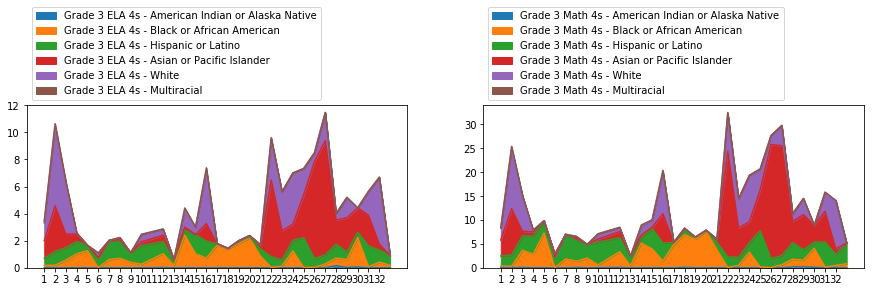

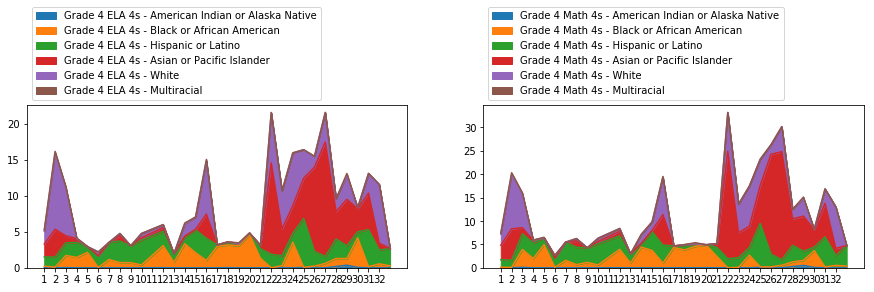

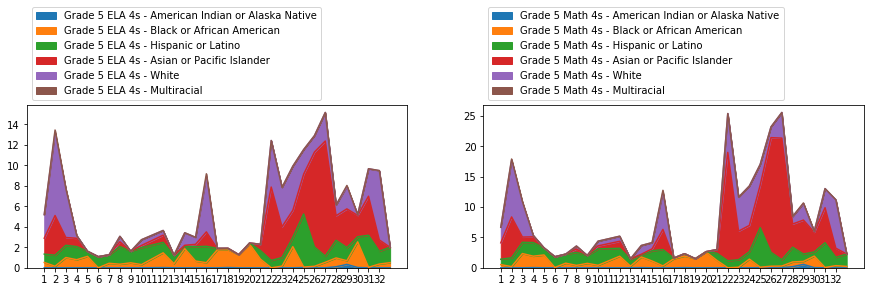

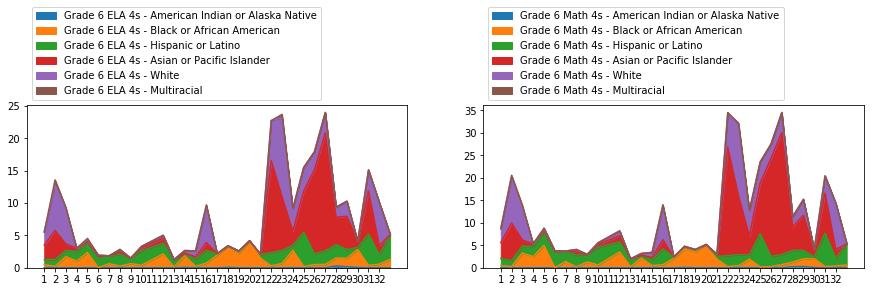

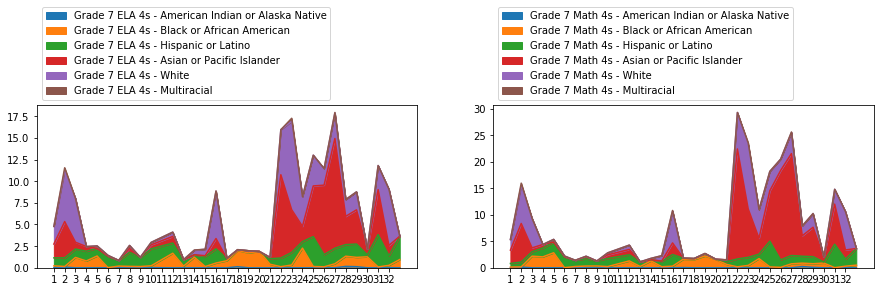

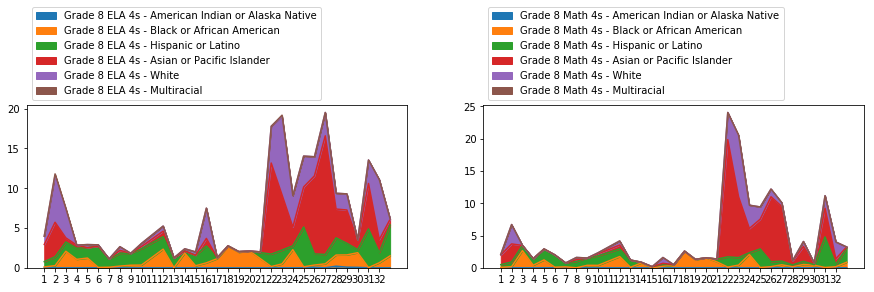

In [387]:
def districts_grade_4s(n):
    fig,ax = plt.subplots(ncols=2, figsize=(15,3))
    for i in [0,1]:
        col=[n+i*10,n+1+i*10,n+2+i*10,n+3+i*10,n+4+i*10,n+5+i*10]
        districts[districts.columns[col]].drop([10]).plot.area(ax=ax[i])
        ax[i].legend(loc=3, bbox_to_anchor=(0, 1))
        ax[i].set_xticks(list(range(0,32)))
        ax[i].set_xticklabels(list(range(1,33)));
        
for d in [24,44,64,84,104,124]:       
    districts_grade_4s(d)

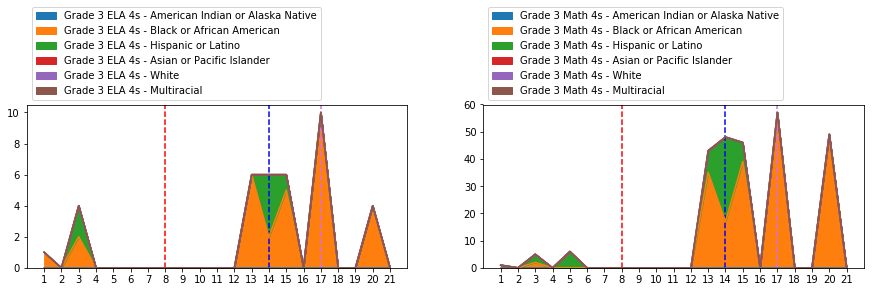

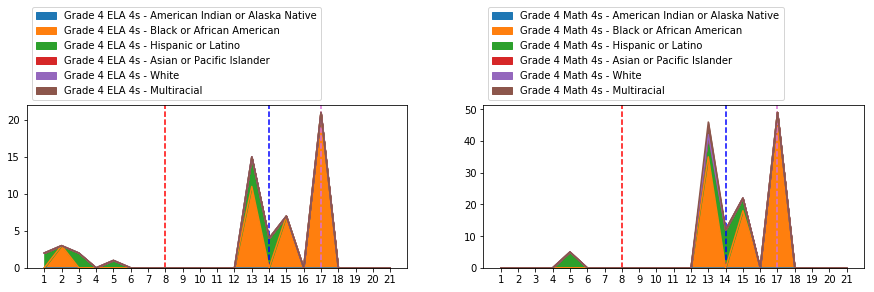

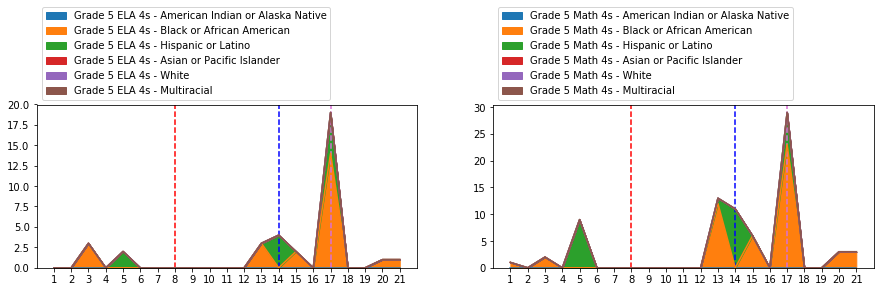

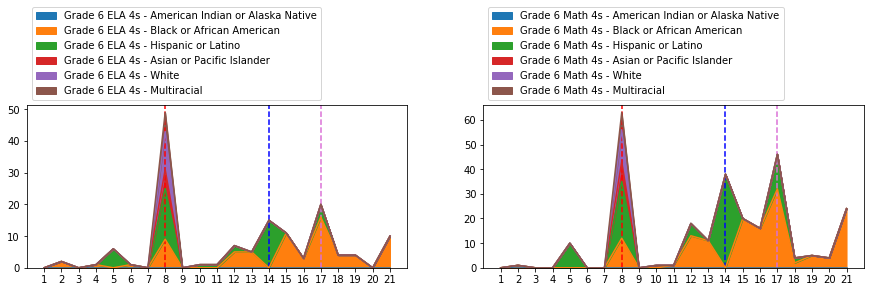

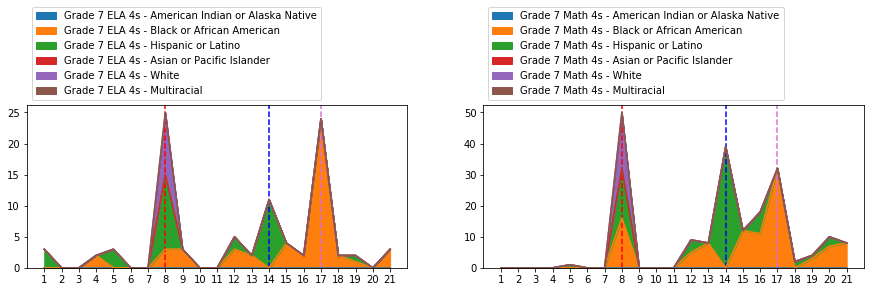

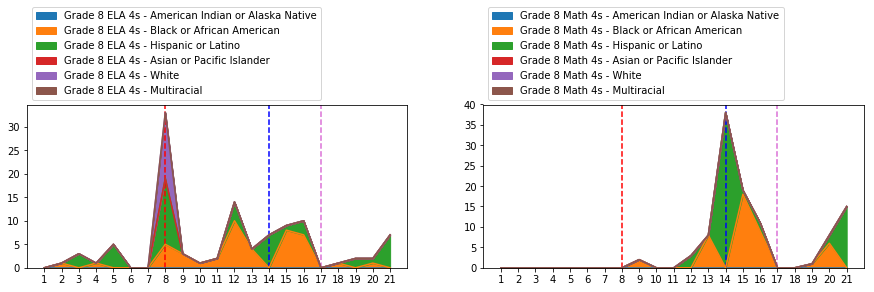

In [403]:
def district5_grade_4s(n):
    fig,ax = plt.subplots(ncols=2, figsize=(15,3))
    for i in [0,1]:
        col=[n+i*10,n+1+i*10,n+2+i*10,n+3+i*10,n+4+i*10,n+5+i*10]
        d5_shsat_2016[d5_shsat_2016.columns[col]].plot.area(ax=ax[i])
        ax[i].vlines(7,0,70,linestyle="--",color='red') 
        ax[i].vlines(13,0,70,linestyle="--",color='blue')
        ax[i].vlines(16,0,70,linestyle="--",color='orchid')
        ax[i].legend(loc=3, bbox_to_anchor=(0, 1))
        ax[i].set_xticks(list(range(0,21)))
        ax[i].set_xticklabels(list(range(1,22)));
        
for d in [21,41,61,81,101,121]:       
    district5_grade_4s(d)

Three leaders among the schools from the 5th District have the different and unique place in the ethnic environment: 

- in one case many groups demonstrate great results, 

- in the second case there are a lot of 'Hispanic or Latino' and 'Black or African American' students and 

- in the third case many 'Black or African American' pupils have high scores.

All these specifics can be used for the choice of a comfortable environment for the concrete student.

## &#x1F310; &nbsp; Social Environment Data Visualization

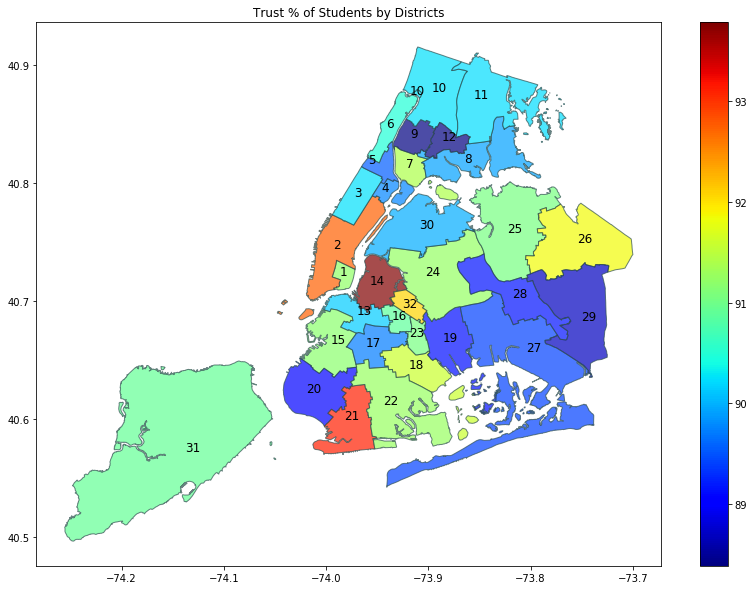

In [413]:
fig,ax = plt.subplots(1, figsize=(14,10))

districts['coords'] = districts['geometry'].apply(lambda x: x.representative_point().coords[:])
districts['coords'] = [coords[0] for coords in districts['coords']]
districts.plot(column='Trust %',ax=ax, legend=True,
               cmap='jet', alpha=0.7, edgecolor='darkslategray')
for idx, row in districts.iterrows():
    plt.annotate(s=row['SchoolDist'], xy=row['coords'],
                 horizontalalignment='center', fontsize=12)
    
plt.title('Trust % of Students by Districts');

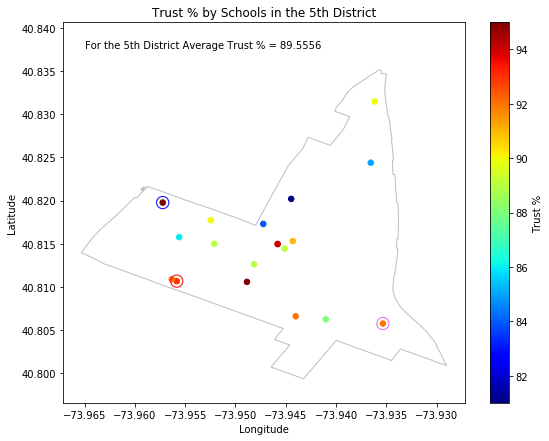

In [410]:
fig = plt.figure(figsize=(9,7)) 
ax = fig.gca() 
ax.add_patch(PolygonPatch(districts.geometry[4],
                          fc='none',ec='slategray', 
                          alpha=0.5,zorder=2 ))
d5_shsat_2016.plot(kind='scatter',x='Longitude',y='Latitude',ax=ax,
                   s=30,c='Trust %',cmap=cm.jet)
ax.scatter(d5_shsat_2016['Longitude'][[7,13,16]],
           d5_shsat_2016['Latitude'][[7,13,16]],
           s=150,facecolors='none',
           edgecolors=['red','blue','orchid'])
ax.text(-73.965,40.8377,
        'For the 5th District Average Trust % = '+\
        str(round(districts['Trust %'][4],4)))
plt.title('Trust % by Schools in the 5th District');